In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torch.utils.data import DataLoader, random_split
from transformers import ViTModel,ViTForImageClassification, ViTConfig
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import resnet50, vit_b_16, mobilenet_v2
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR
import csv


In [2]:
class Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): CSV文件的路径，包含文件名和标签。
            img_dir (string): 图片文件的目录。
            transform (callable, optional): 可选的转换操作，应用于图片。
        """
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
def create_dataloader(csv_file, img_dir, batch_size, transform, val_split=0.25):
    dataset = Dataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
    
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # 创建训练集和验证集的DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, val_dataloader

In [3]:
# 你可以根据需要修改下面的转换操作
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.GaussianBlur(kernel_size=(15, 15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.3 , saturation = 0.2, hue=0.3), #random brightness, contrast etc
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # ImageNet prior
])

In [4]:
csv_file = './data/train.csv'
img_dir = './data/train/train_images/'
batch_size = 32

In [5]:
train_loader, val_loader = create_dataloader(csv_file, img_dir, batch_size, transform)

# 用一个循环来查看数据
for images, labels in train_loader:
    print(images.shape, labels)
    break

# label
# 3    13158
# 4     2577
# 2     2386
# 1     2189
# 0     1087

torch.Size([32, 3, 224, 224]) tensor([1, 3, 0, 3, 3, 2, 3, 3, 2, 3, 1, 4, 3, 3, 3, 3, 2, 3, 2, 3, 2, 0, 0, 1,
        4, 3, 3, 3, 3, 3, 3, 3])


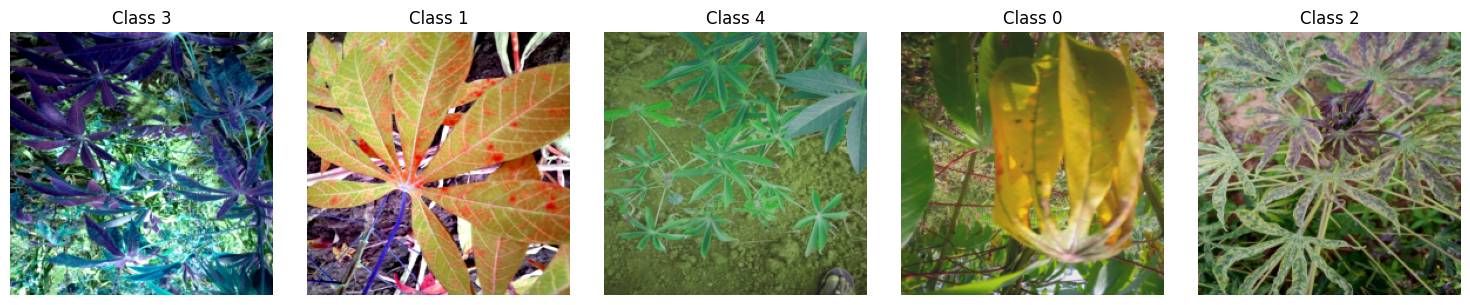

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, ax):
    # 将Tensor图像转换为NumPy，进行反标准化
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # 反标准化
    img = np.clip(img, 0, 1)  # 将图像剪切到0-1之间
    ax.imshow(img)
    ax.axis('off')  # 隐藏坐标轴

# 获取一批数据
images, labels = next(iter(train_loader))

# 记录已选择的类别
selected_classes = set()

# 存储每个类别的第一个图像
class_images = {}

for i, label in enumerate(labels):
    label = label.item()
    if label not in selected_classes:
        # 把该类别的图像添加到字典中
        class_images[label] = images[i]
        selected_classes.add(label)
    if len(class_images) == len(set(labels.tolist())):  # 如果我们已经选出了每个类别的图像
        break

# 确保我们有一个轴用于每个类别的图像
fig, axes = plt.subplots(1, len(class_images), figsize=(15, 3))
axes = axes.flatten() if len(class_images) > 1 else [axes]  # 确保axes是列表

# 绘制每个类别的图像
for ax, (cls, img) in zip(axes, class_images.items()):
    ax.set_title(f'Class {cls}')
    imshow(img, ax)

plt.tight_layout()
plt.show()


In [7]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        # 加载预训练的模型
        self.vit = vit_b_16(pretrained=True)
        self.resnet = resnet50(pretrained=True)
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.mobilenet = mobilenet_v2(pretrained=True)

        # 移除原有的分类层
        self.vit.heads = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.efficientnet._fc = nn.Identity()
        self.mobilenet.classifier = nn.Identity()

        # 添加新的全连接层，用于将输出调整为5个类别
        self.fc_vit = nn.Linear(768, 5)
        self.fc_resnet = nn.Linear(2048, 5)
        self.fc_efficientnet = nn.Linear(1280, 5)
        self.fc_mobilenet = nn.Linear(1280, 5)

    def forward(self, x):
        # 获取各个模型的输出，并通过新的全连接层转换为5分类输出
        vit_output = self.fc_vit(self.vit(x))
        resnet_output = self.fc_resnet(self.resnet(x))
        efficientnet_output = self.fc_efficientnet(self.efficientnet(x))
        mobilenet_output = self.fc_mobilenet(self.mobilenet(x))

        # 平均 ViT 和 ResNet 的输出
        average_output = (vit_output + resnet_output) / 2

        # 将平均值与 EfficientNet 和 MobileNet 的输出相加
        combined_output = average_output + efficientnet_output + mobilenet_output

        # 使用 softmax 得到最终的预测概率
        predictions = torch.softmax(combined_output, dim=1)

        return predictions


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy: {100 * correct / total}%')

    print('Finished Training')


In [10]:
model = CombinedModel().to(device)

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `w

Loaded pretrained weights for efficientnet-b0


/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# train the model
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1/1087, 1/2189, 1/2386, 1/2577, 1/13158]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # 每30个epoch学习率乘以0.1

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Epoch 1, Loss: 1.1793449275284649
Validation Accuracy: 71.75172929519536%
Epoch 2, Loss: 1.132067622772726
Validation Accuracy: 71.37782763133296%
Epoch 3, Loss: 1.1099518757179914
Validation Accuracy: 73.34081136661058%
Epoch 4, Loss: 1.0961506909345726
Validation Accuracy: 74.42512619181156%
Epoch 5, Loss: 1.083903702606718
Validation Accuracy: 75.54683118339877%
Epoch 6, Loss: 1.0669689648654832
Validation Accuracy: 75.90203776406806%
Epoch 7, Loss: 1.0583928885212932
Validation Accuracy: 76.5002804262479%
Epoch 8, Loss: 1.0544712820138589
Validation Accuracy: 76.81809684053094%
Epoch 9, Loss: 1.0506993057243377
Validation Accuracy: 76.79940175733782%
Epoch 10, Loss: 1.051074397991378
Validation Accuracy: 76.66853617498597%


KeyboardInterrupt: 

In [12]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, img_name

In [13]:
# 定义图像转换操作
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小
    transforms.ToTensor(),          # 转换为tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建数据集实例
dataset = ImageDataset(directory='./data/test/test_images/', transform=transform)

# 创建 DataLoader
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [25]:
def test_model(model, test_loader):
    model.eval()
    results = []
    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            
            # 使用 torch.argmax 获取预测结果中概率最高的类别的索引
            _, predicted_labels = torch.max(outputs, 1)
            
            for filename, prediction in zip(filenames, predicted_labels):
                results.append([filename, prediction.item()])  # prediction.item() 将 Tensor 转换为 Python 数字

    # 保存结果到 CSV
    with open('submission.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_id', 'label'])
        writer.writerows(results)


In [26]:
# 调用测试函数
test_model(model, test_loader)